# Chapter 3 분류

In [40]:
import numpy as np

## 3.1 MNIST

In [1]:
# MNIST 가져오기
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [12]:
print(X)

       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel7

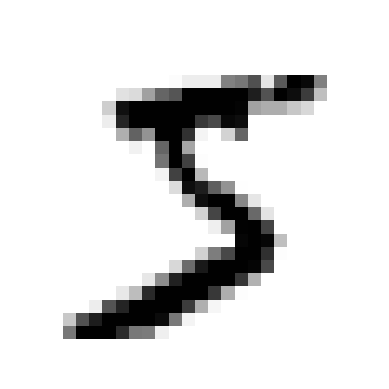

In [14]:
# 데이터 출력해보기
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape((28, 28))

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [17]:
# 레이블 데이터 타입 정수로 변환
y = y.astype('uint8')

In [18]:
# 훈련 세트와, 테스트 세트 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [19]:
# 5를 분류하는 이진 분류기를 위한 레이블
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [20]:
# 모델 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [23]:
sgd_clf.predict([some_digit])

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [25]:
# cross_val_score() 함수를 이용한 k-겹 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96825, 0.9445 , 0.9682 ])

### 3.3.2 오차 행렬

In [26]:
# 실제 타깃과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
# confusion_matrix() 함수로 오차 행렬 만들기
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

[[54037   542]
 [ 1653  3768]]


오차 행렬의 행은 `실제 클래스`, 열은 `예측한 클래스`를 나타낸다. 위에서 구한 오차 행렬은 다음과 같이 나타낸다.
|     |     음성     |     양성     |
|:---:|:------------:|:------------:|
|음성 |true negative |false positive|
|양성 |false negative|true positive |

분류기 에선 이 오차 행렬을 사용해 요약된 지표를 얻을 수 있다.
* 정밀도(precision): $\dfrac{TP}{TP+FP}$
* 재현율(recall, sensitivity): $\dfrac{TP}{TP+FN}$

### 3.3.3 정밀도와 재현율

In [30]:
# 정밀도와 재현율 구하기
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.874245939675174
0.6950747094631987


$F_1$ 점수: 정밀도와 재현율의 `조화 평균`(harmonic mean)
* $F_1 = \dfrac{2}{\dfrac{1}{precision} + \dfrac{1}{recall}}$
* precision 과 recall이 비슷한 분류이게선 $F_1$ 점수가 높다.
* 상황에 따라 정밀도가 중요한 분류기를 만들어야 될 수도 있고, 재현율이 좋은 분류기를 만들어야할 수도 있다.

### 3.3.4 정밀도/재현율 트레이드오프

In [31]:
# cross_val_predict() 함수에서 결정 점수 반환 받기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [32]:
# 위 점수로 precision_recall_curve() 함수를 사용해 가능한 모든 임곗갑ㅅ에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [36]:
# 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.legend()

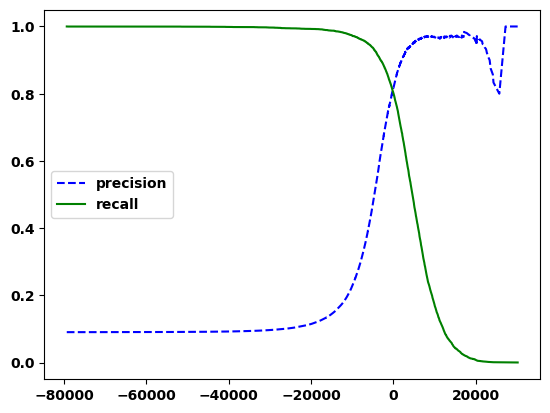

In [37]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

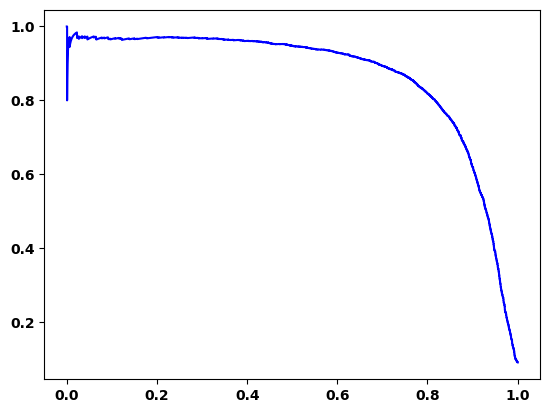

In [38]:
# 정밀도와 재현율 그래프 그리기
plt.plot(recalls, precisions, c='b')

In [41]:
# 정밀도 90%가 되는 임곗값 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [42]:
# 훈련 세트에 대한 예측 만들기
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
# 위 예측에 대한 정밀도와 재현율 확인
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.9
0.6889872717210846


위같은 과정을 거치면 정밀도 90%의 분류기를 만들 수 있다.

### 3.3.5 ROC 곡선
오차 행렬의 행은 `실제 클래스`, 열은 `예측한 클래스`를 나타낸다.
|     |     음성     |     양성     |
|:---:|:------------:|:------------:|
|음성 |true negative |false positive|
|양성 |false negative|true positive |

* ROC 곡선은 x축에 False Positive Rate(FPR)을, y축에 True Positive Rate(TPR)을 나타낸다. 
* FPR은 실제 음성인 샘플 중에서 모델이 양성으로 잘못 분류한 비율을 나타낸다.
  * $FPR = \dfrac{FP}{FP + TN}$
* TPR은 실제 양성인 샘플 중에서 모델이 양성으로 정확하게 분류한 비율을 나타낸다.
  * $TPR = \dfrac{TP}{TP + FN}$

* 분류 모델이 무작위로 분류하는 경우, ROC 곡선은 y=x에 가까운 대각선이 된다.
* 좋은 분류 모델은 ROC 곡선이 y=x에 가깝지 않고, 왼쪽 상단 모서리에 가까워지도록 한다.
* ROC 곡선의 면적(Area Under the Curve, AUC)은 분류 모델의 성능을 요약하는 지표이다. 
* AUC 값이 1에 가까울수록 분류 모델의 성능이 좋다는 것을 의미한다.

In [45]:
# roc 그래프 그리기
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

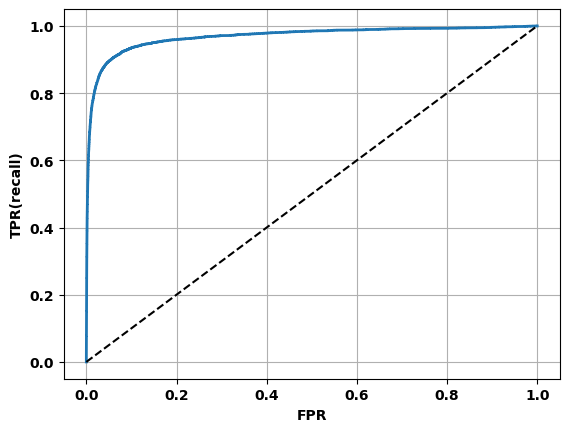

In [50]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR(recall)')
    plt.grid('True')

plot_roc_curve(fpr, tpr)
plt.show()

In [52]:
# AUC 측정
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9684273333186447

* PR 곡선은 정밀도(precision)와 재현율(recall)을 나타내며, 이진 분류 모델에서 불균형한 클래스 분포(unbalanced class distribution)를 가지는 데이터셋에서 사용됩니다. 
* 예를 들어, 암 진단을 예측하는 모델에서 정상 진단이 매우 많은 경우(음성 클래스가 많은 경우)에 PR 곡선을 사용합니다. 
* PR 곡선은 분류 모델이 양성 클래스를 잘 분류하는지에 대한 지표로 사용됩니다.
---
* 반면에 ROC 곡선은 FPR(False Positive Rate)과 TPR(True Positive Rate)을 나타내며, 분류 모델에서 불균형한 클래스 분포를 가지지 않는 경우에 사용됩니다. 
* ROC 곡선은 분류 모델이 양성 클래스를 잘 분류하는 능력 뿐만 아니라, 음성 클래스를 잘 분류하는 능력도 포함합니다. 
* ROC 곡선은 분류 모델의 예측 성능을 요약하는 지표인 AUC(Area Under the Curve)를 계산할 수 있습니다.
---
* 따라서, PR 곡선은 클래스 불균형 데이터에서 성능 평가를 위해 사용되고, ROC 곡선은 일반적인 이진 분류 문제에서 성능 평가를 위해 사용됩니다.

In [53]:
# RandomForestClassifier와 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교
# RandomForestClassifier에는 decision_function이 없어 predict_proba를 대신 사용
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_porbas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [55]:
# 양성 클래스에 대한 확률을 점수로 사용
y_scores_forest = y_porbas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

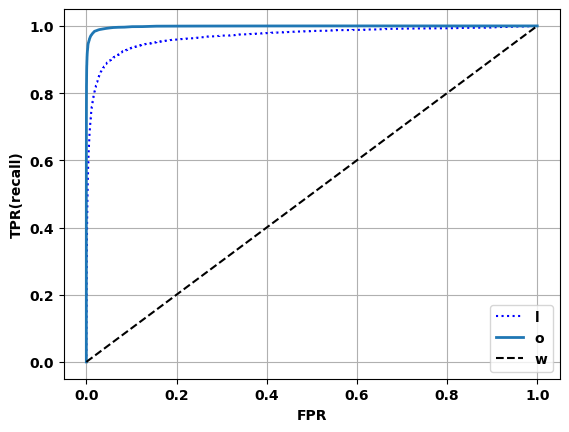

In [56]:
# ROC 곡선 비교
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForest')
plt.legend('lower right')
plt.show()

In [57]:
# random forest AUC 점수 계산
roc_auc_score(y_train_5, y_scores_forest)

0.9984247890830666

## 3.4 다중 분류
`다중 분류기`(multiclass classifier): 둘 이상의 클래스를 구별할 수 있는 분류기

* `OvR`(one-versus-the-rest): 하나의 숫자만 구분하는 숫자별 이진 분류기 10개를 훈련시키는 것
* `OvO`(one-versus-one): 0과 1, 0과 2, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련 시키는 것


In [58]:
# 서포트 벡터 머신 분류기 테스트
# 사이킷런에선 자동으로 OvO 전략을 사용한다.
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [59]:
# 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but S

array([5], dtype=uint8)

In [60]:
# SGDClassifier(또는 RandomForestClassifier)를 훈련시키는 것도 위와 같이 하면된다.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [61]:
# SGDClassifier는 직접 샘플을 다중 클래스로 분류할 수 있다.
# 클래스마다 하나의 값을 반환
sgd_clf.decision_function([some_digit])

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-15586.16627766, -27299.56157199, -10974.61470278,
          -481.22690558, -17244.19473706,    477.60514812,
        -29360.48562919, -11070.24046265,  -8722.70563671,
         -9187.65645527]])

In [62]:
# SGDClassifier 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8768, 0.884 , 0.8851])

In [63]:
# 입력 스케일을 조정하면 정확도를 조금 높일 수 있다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')


c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.8948 , 0.89865, 0.90325])

## 3.5 에러 분석

In [64]:
# 오차 행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5591,    0,   22,    6,    8,   48,   36,    6,  205,    1],
       [   0, 6407,   36,   27,    4,   46,    4,    8,  198,   12],
       [  27,   28, 5239,   95,   73,   29,   69,   37,  350,   11],
       [  25,   17,  115, 5251,    2,  219,   26,   41,  364,   71],
       [  11,   14,   46,   12, 5219,   12,   35,   25,  298,  170],
       [  29,   15,   30,  176,   54, 4489,   73,   15,  478,   62],
       [  29,   15,   44,    2,   44,   98, 5558,    4,  123,    1],
       [  22,   11,   53,   31,   49,   13,    3, 5707,  167,  209],
       [  18,   66,   44,   91,    3,  129,   25,   11, 5420,   44],
       [  25,   18,   30,   70,  122,   40,    1,  177,  328, 5138]],
      dtype=int64)

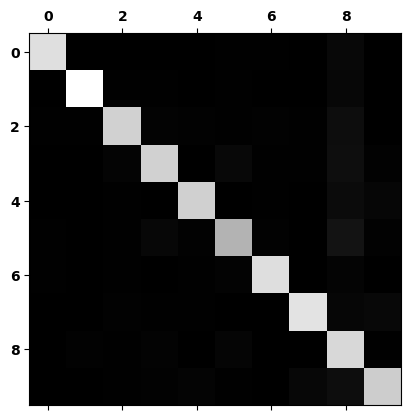

In [65]:
# 오차 행렬 이미지
plt.matshow(conf_mx, cmap='gray')

In [66]:
# 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx / row_sums

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


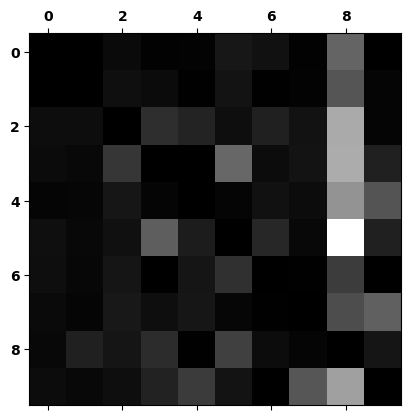

In [67]:
# 대각선을 0으로 채워 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='gray')
plt.show()

* 클래스 8의 열이 밝게 표시된 것을 보면 많은 이미지가 8로 잘못 분류된 것을 알 수 있다.
* 하지만 클래스 8의 행을 보면 실제 8이 클래스 8로 적절히 분류된 것을 알 수 있다.
* 3과 5가 서로 혼동이 되고 있는 것을 볼 수 있다.
* 2와 3도 서로 혼동이 되고 있는 것을 볼 수 있다.

## 3.6 다중 레이블 분류
샘플마다 여러 개의 클래스를 분류

In [68]:
# 예시
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [69]:
knn_clf.predict([some_digit])

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [70]:
from sklearn.metrics import f1_score
# 다중 레이블 분류기 평가 방법(F_1 점수)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## 3.7 다중 출력 분류
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것. 즉, 값을 두 개 이상 가질 수 있다.

예시로서, 이미지에서 잡음을 제거하는 시스템을 만들어보겠다.

In [91]:
# 훈련 세트와 테스트 세트에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

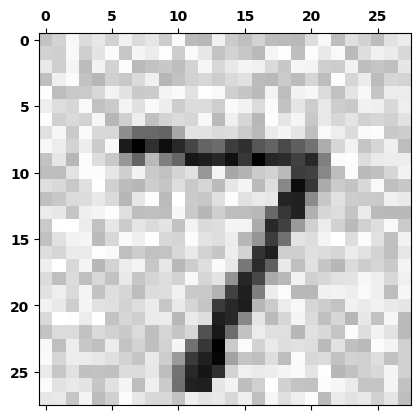

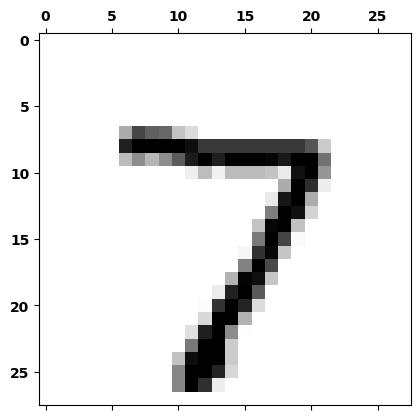

In [92]:
some_num = np.asarray_chkfinite(X_test_mod)[0]
some_num_y = np.asarray_chkfinite(y_test_mod)[0]

plt.matshow(some_num.reshape(28, 28), cmap='binary')
plt.show()
plt.matshow(some_num_y.reshape(28, 28), cmap='binary')
plt.show()

c:\Users\sm136\.conda\envs\tf2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


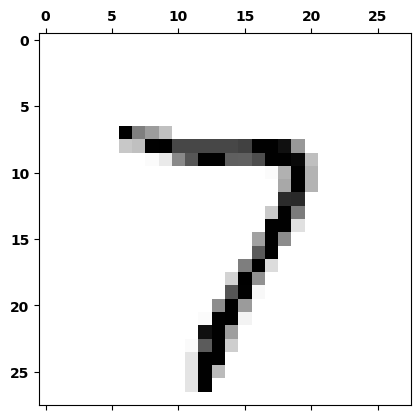

In [93]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_num])
plt.matshow(clean_digit.reshape(28, 28), cmap='binary')
plt.show()

## 3.8 연습문제
